In [1]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()
y = olivetti.target

In [2]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

In [3]:
olivetti.data.shape

(400, 4096)

# Show Distinct People in the Olivetti Dataset

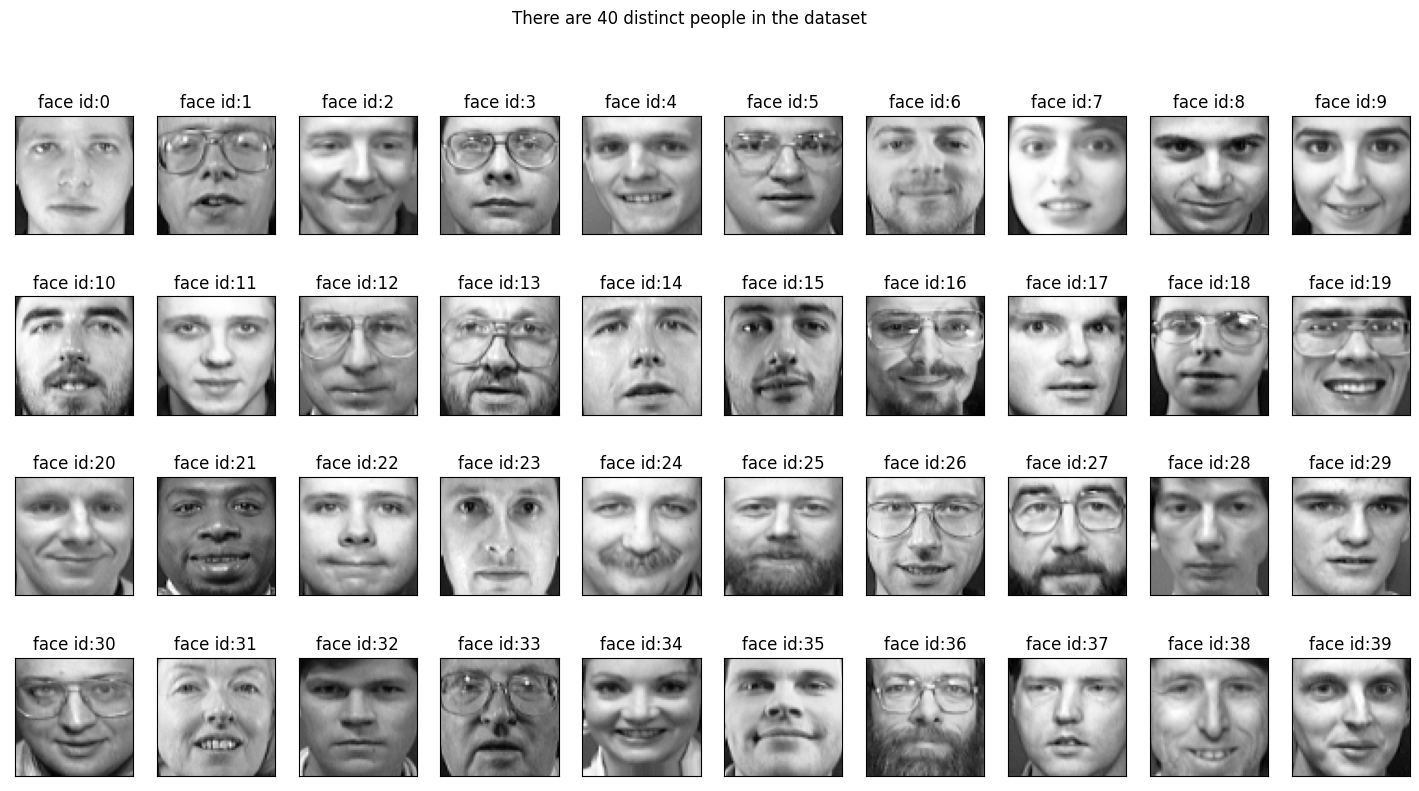

In [4]:
olivetti_3d = olivetti.data.reshape(400, 64, 64)

import matplotlib.pyplot as plt
import numpy as np

def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()

    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle("There are 40 distinct people in the dataset")

show_40_distinct_people(olivetti_3d, np.unique(y))

# PCA

In [5]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X = pca.fit_transform(olivetti.data)

pca.n_components_

260

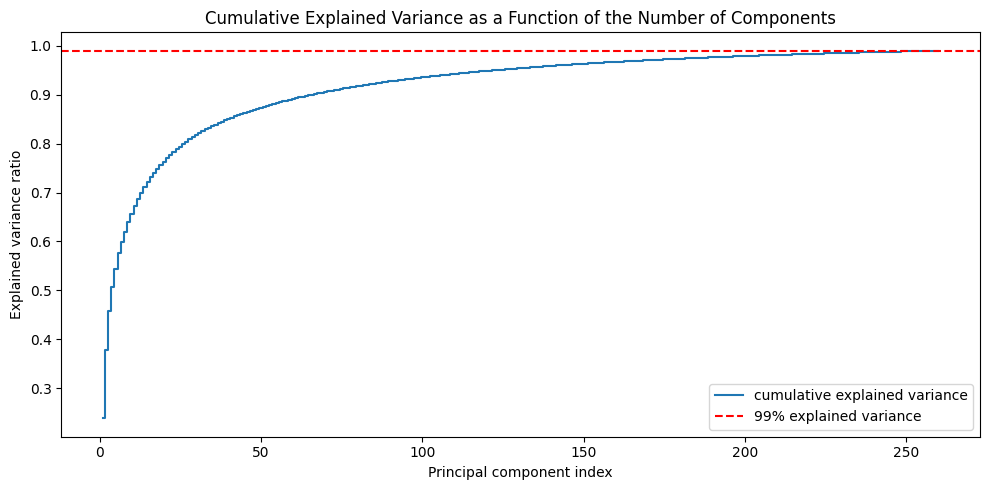

In [62]:
# Get the number of components
n_components = pca.n_components_

# Calculate the cumulative sum of explained variance ratios
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plotting
plt.figure(figsize=(10, 5))

plt.step(range(1, n_components + 1), cumulative_variance, where='mid',
         label='cumulative explained variance')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

# K-Means

In [9]:
from sklearn.cluster import KMeans

k_range = range(5, 200)
kmeans_per_k = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X)
    kmeans_per_k.append(kmeans)


## K-Means Silhouette Score

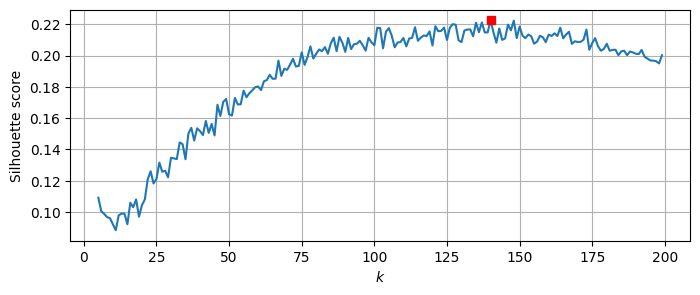

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores)
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.plot(best_k, best_score, "rs")
plt.grid()
plt.show()

In [11]:
print(f'best k : {best_k}\nbest score: {best_score}')

best k : 140
best score: 0.22261455655097961


It looks like the best number of clusters is quite high, at 140. You might have expected it to be 40, since there are 40 different people on the pictures. However, the same person may look quite different on different pictures (e.g., with or without glasses, or simply shifted left or right).

## K-Means Inertias

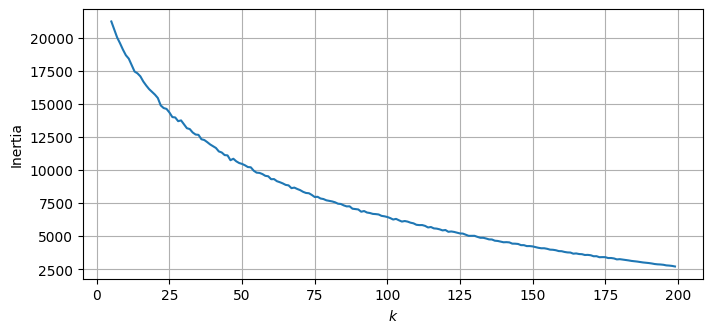

In [13]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias)
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.grid()
plt.show()

The optimal number of clusters is not clear on this inertia diagram, as there is no obvious elbow, so let's stick with k=___.

# Visualize the clusters

In [ ]:
best_model = kmeans_per_k[best_index]

def plot_faces(faces, labels, n_cols=6):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = olivetti.data[in_cluster]
    labels = y[in_cluster]
    plot_faces(faces, labels)


About 2 out of 3 clusters are useful: that is, they contain at least 2 pictures, all of the same person. However, the rest of the clusters have either one or more intruders, or they have just a single picture.

Clustering images this way may be too imprecise to be directly useful when training a model (as we will see below), but it can be tremendously useful when labeling images in a new dataset: it will usually make labelling much faster.

## Take a look at when k=40

In [ ]:
# kmeans_40 = KMeans(n_clusters=40, n_init=10, random_state=42)
# kmeans_40.fit(X)

# for cluster_id in np.unique(kmeans_40.labels_):
#     print("Cluster", cluster_id)
#     in_cluster = kmeans_40.labels_==cluster_id
#     faces = olivetti.data[in_cluster]
#     labels = y[in_cluster]
#     plot_faces(faces, labels)

# Agglomerative Clustering

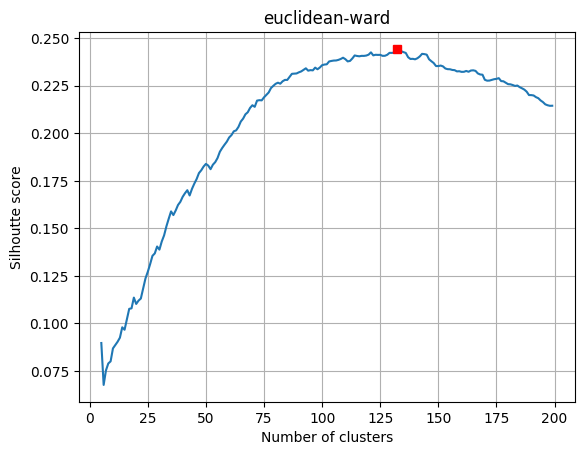

In [18]:
from sklearn.cluster import AgglomerativeClustering

# euclidean-ward
silhouette_scores = []
for n_clusters in k_range:
    agg_clustering = AgglomerativeClustering(n_clusters = n_clusters,
                                             affinity='euclidean',
                                             linkage='ward')
    agg_labels = agg_clustering.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, agg_labels))

best_index_euclidean_ward = np.argmax(silhouette_scores)
best_k_euclidean_ward = k_range[best_index_euclidean_ward]
best_score_euclidean_ward = silhouette_scores[best_index_euclidean_ward]

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.title('euclidean-ward')
plt.plot(best_k_euclidean_ward, best_score_euclidean_ward, "rs")
plt.grid()
plt.show()


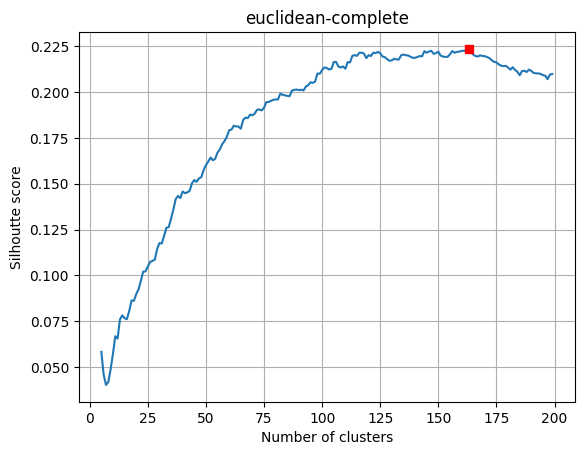

In [19]:
# euclidean-complete
silhouette_scores = []
for n_clusters in k_range:
    agg_clustering = AgglomerativeClustering(n_clusters = n_clusters,
                                             affinity='euclidean',
                                             linkage='complete')
    agg_labels = agg_clustering.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, agg_labels))

best_index_euclidean_complete = np.argmax(silhouette_scores)
best_k_euclidean_complete = k_range[best_index_euclidean_complete]
best_score_euclidean_complete = silhouette_scores[best_index_euclidean_complete]

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.title('euclidean-complete')
plt.plot(best_k_euclidean_complete, best_score_euclidean_complete, "rs")
plt.grid()
plt.show()

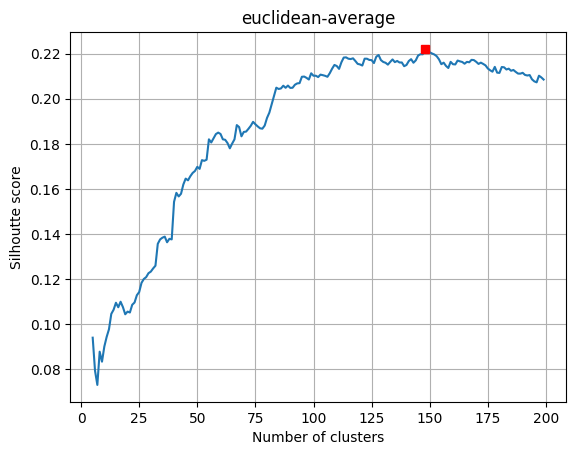

In [20]:
# euclidean-average
silhouette_scores = []
for n_clusters in k_range:
    agg_clustering = AgglomerativeClustering(n_clusters = n_clusters,
                                             affinity='euclidean',
                                             linkage='average')
    agg_labels = agg_clustering.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, agg_labels))

best_index_euclidean_average = np.argmax(silhouette_scores)
best_k_euclidean_average = k_range[best_index_euclidean_average]
best_score_euclidean_average = silhouette_scores[best_index_euclidean_average]

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.title('euclidean-average')
plt.plot(best_k_euclidean_average, best_score_euclidean_average, "rs")
plt.grid()
plt.show()

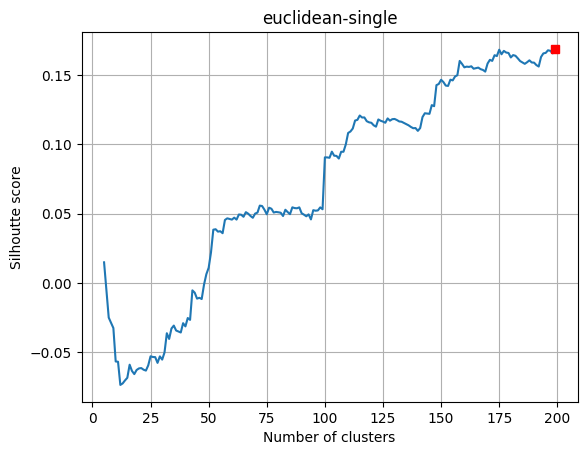

In [21]:
# euclidean-single
silhouette_scores = []
for n_clusters in k_range:
    agg_clustering = AgglomerativeClustering(n_clusters = n_clusters,
                                             affinity='euclidean',
                                             linkage='single')
    agg_labels = agg_clustering.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, agg_labels))

best_index_euclidean_single = np.argmax(silhouette_scores)
best_k_euclidean_single = k_range[best_index_euclidean_single]
best_score_euclidean_single = silhouette_scores[best_index_euclidean_single]

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.title('euclidean-single')
plt.plot(best_k_euclidean_single, best_score_euclidean_single, "rs")
plt.grid()
plt.show()

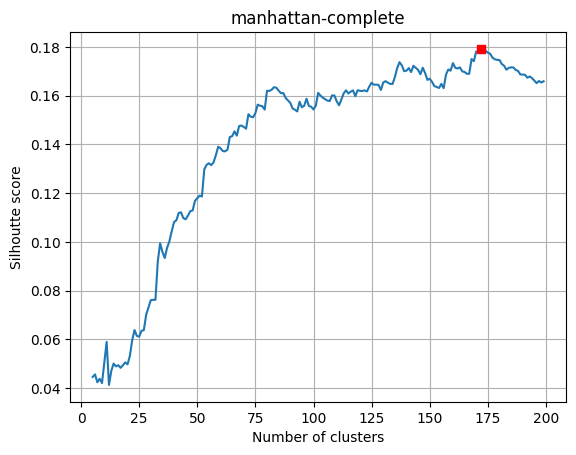

In [22]:
# manhattan-complete
silhouette_scores = []
for n_clusters in k_range:
    agg_clustering = AgglomerativeClustering(n_clusters = n_clusters,
                                             affinity='manhattan',
                                             linkage='complete')
    agg_labels = agg_clustering.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, agg_labels))

best_index_manhattan_complete = np.argmax(silhouette_scores)
best_k_manhattan_complete = k_range[best_index_manhattan_complete]
best_score_manhattan_complete = silhouette_scores[best_index_manhattan_complete]

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.title('manhattan-complete')
plt.plot(best_k_manhattan_complete, best_score_manhattan_complete, "rs")
plt.grid()
plt.show()


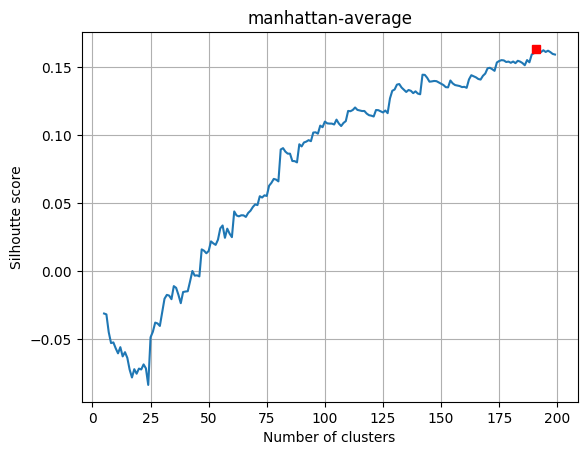

In [23]:
# manhattan-average
silhouette_scores = []
for n_clusters in k_range:
    agg_clustering = AgglomerativeClustering(n_clusters = n_clusters,
                                             affinity='manhattan',
                                             linkage='average')
    agg_labels = agg_clustering.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, agg_labels))

best_index_manhattan_average = np.argmax(silhouette_scores)
best_k_manhattan_average = k_range[best_index_manhattan_average]
best_score_manhattan_average = silhouette_scores[best_index_manhattan_average]

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.title('manhattan-average')
plt.plot(best_k_manhattan_average, best_score_manhattan_average, "rs")
plt.grid()
plt.show()

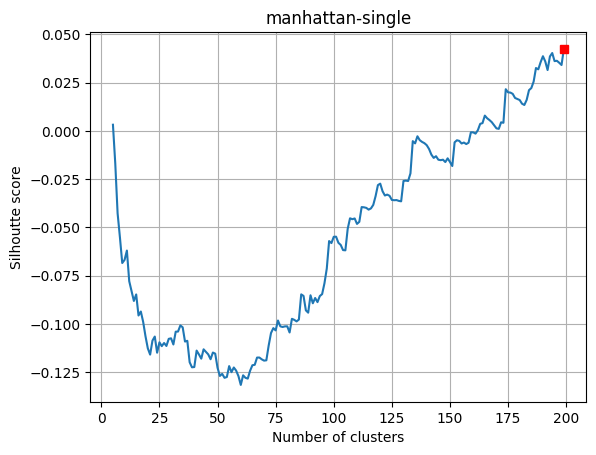

In [24]:
# manhattan-single
silhouette_scores = []
for n_clusters in k_range:
    agg_clustering = AgglomerativeClustering(n_clusters = n_clusters,
                                             affinity='manhattan',
                                             linkage='single')
    agg_labels = agg_clustering.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, agg_labels))

best_index_manhattan_single = np.argmax(silhouette_scores)
best_k_manhattan_single = k_range[best_index_manhattan_single]
best_score_manhattan_single = silhouette_scores[best_index_manhattan_single]

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.title('manhattan-single')
plt.plot(best_k_manhattan_single, best_score_manhattan_single, "rs")
plt.grid()
plt.show()

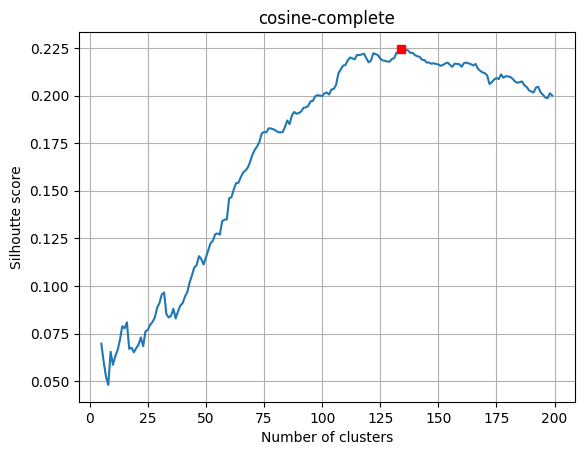

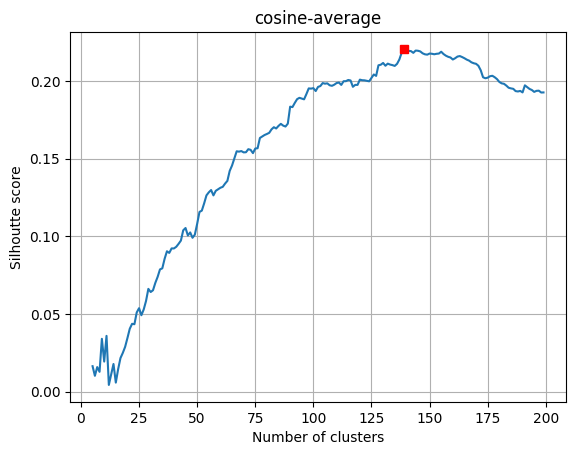

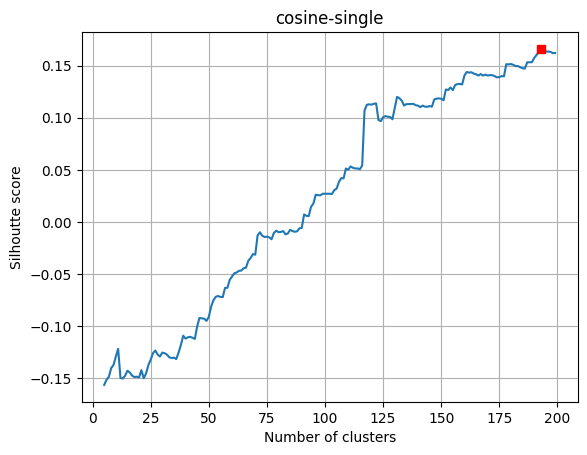

In [29]:
# cosine-complete
silhouette_scores = []
for n_clusters in k_range:
    agg_clustering = AgglomerativeClustering(n_clusters = n_clusters,
                                             affinity='cosine',
                                             linkage='complete')
    agg_labels = agg_clustering.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, agg_labels))

best_index_cosine_complete = np.argmax(silhouette_scores)
best_k_cosine_complete = k_range[best_index_cosine_complete]
best_score_cosine_complete = silhouette_scores[best_index_cosine_complete]

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.title('cosine-complete')
plt.plot(best_k_cosine_complete, best_score_cosine_complete, "rs")
plt.grid()
plt.show()

# cosine-average
silhouette_scores = []
for n_clusters in k_range:
    agg_clustering = AgglomerativeClustering(n_clusters = n_clusters,
                                             affinity='cosine',
                                             linkage='average')
    agg_labels = agg_clustering.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, agg_labels))

best_index_cosine_average = np.argmax(silhouette_scores)
best_k_cosine_average = k_range[best_index_cosine_average]
best_score_cosine_average = silhouette_scores[best_index_cosine_average]

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.title('cosine-average')
plt.plot(best_k_cosine_average, best_score_cosine_average, "rs")
plt.grid()
plt.show()

# cosine-single
silhouette_scores = []
for n_clusters in k_range:
    agg_clustering = AgglomerativeClustering(n_clusters = n_clusters,
                                             affinity='cosine',
                                             linkage='single')
    agg_labels = agg_clustering.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, agg_labels))

best_index_cosine_single = np.argmax(silhouette_scores)
best_k_cosine_single = k_range[best_index_cosine_single]
best_score_cosine_single = silhouette_scores[best_index_cosine_single]

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.title('cosine-single')
plt.plot(best_k_cosine_single, best_score_cosine_single, "rs")
plt.grid()
plt.show()


## Compare the result

In [31]:
results = {
    "Configuration": ["euclidean-ward", "euclidean-complete", "euclidean-average", "euclidean-single",
                      "manhattan-complete", "manhattan-average", "manhattan-single",
                      "cosine-complete", "cosine-average", "cosine-single"],
    "Best K": [best_k_euclidean_ward, best_k_euclidean_complete, best_k_euclidean_average, best_k_euclidean_single,
               best_k_manhattan_complete, best_k_manhattan_average, best_k_manhattan_single,
               best_k_cosine_complete, best_k_cosine_average, best_k_cosine_single],
    "Best Silhouette Score": [best_score_euclidean_ward, best_score_euclidean_complete, best_score_euclidean_average, best_score_euclidean_single,
                              best_score_manhattan_complete, best_score_manhattan_average, best_score_manhattan_single,
                              best_score_cosine_complete, best_score_cosine_average, best_score_cosine_single]
}

# Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Display the DataFrame
print(df_results)

        Configuration  Best K  Best Silhouette Score
0      euclidean-ward     132               0.244383
1  euclidean-complete     163               0.223546
2   euclidean-average     148               0.222101
3    euclidean-single     199               0.168866
4  manhattan-complete     172               0.179192
5   manhattan-average     191               0.163170
6    manhattan-single     199               0.042458
7     cosine-complete     134               0.224513
8      cosine-average     139               0.220701
9       cosine-single     193               0.165933


## Visualize the Configuration with Best Score




In [ ]:
best_agg_clustering = AgglomerativeClustering(n_clusters = 120,
                                             affinity='euclidean',
                                             linkage='ward')

best_agg_labels = best_agg_clustering.fit_predict(X)

for cluster_id in np.unique(best_agg_labels):
    print("Cluster", cluster_id)
    in_cluster = best_agg_labels==cluster_id
    faces = olivetti.data[in_cluster]
    labels = y[in_cluster]
    plot_faces(faces, labels)

# DBSCAN

In [33]:
from sklearn.cluster import DBSCAN

dbscan_results = {}
for eps in np.arange(1, 10.5, 0.5):
    dbscan = DBSCAN(eps=eps, min_samples=2)
    dbscan.fit(X)
    dbscan_results[eps] = dbscan.labels_

for eps, labels in dbscan_results.items():
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_points = np.count_nonzero(labels == -1)
    print(f'eps: {eps:.1f}, clusters: {n_clusters}')
    print('Number of noise points:', n_noise_points)

eps: 1.0, clusters: 0
Number of noise points: 400
eps: 1.5, clusters: 2
Number of noise points: 396
eps: 2.0, clusters: 5
Number of noise points: 390
eps: 2.5, clusters: 8
Number of noise points: 384
eps: 3.0, clusters: 13
Number of noise points: 372
eps: 3.5, clusters: 22
Number of noise points: 348
eps: 4.0, clusters: 44
Number of noise points: 297
eps: 4.5, clusters: 61
Number of noise points: 239
eps: 5.0, clusters: 67
Number of noise points: 194
eps: 5.5, clusters: 74
Number of noise points: 150
eps: 6.0, clusters: 68
Number of noise points: 106
eps: 6.5, clusters: 59
Number of noise points: 66
eps: 7.0, clusters: 47
Number of noise points: 43
eps: 7.5, clusters: 36
Number of noise points: 21
eps: 8.0, clusters: 16
Number of noise points: 11
eps: 8.5, clusters: 12
Number of noise points: 5
eps: 9.0, clusters: 5
Number of noise points: 2
eps: 9.5, clusters: 2
Number of noise points: 0
eps: 10.0, clusters: 1
Number of noise points: 0


# GMM

In [34]:
from sklearn.mixture import GaussianMixture

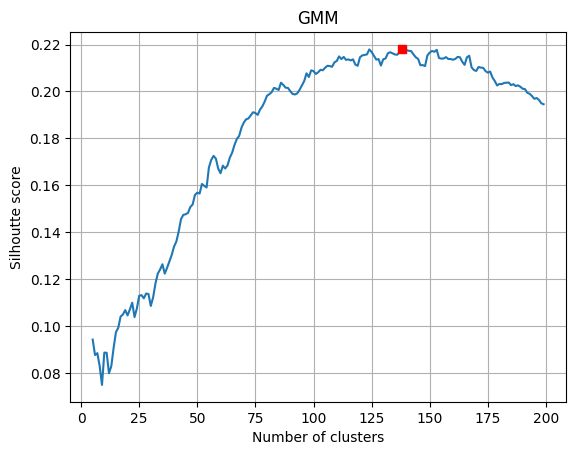

In [35]:
silhouette_scores = []
for n_clusters in k_range:
    gmm = GaussianMixture(n_components=n_clusters,
                          random_state=42)
    gmm_labels = gmm.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, gmm_labels))

best_index_gmm = np.argmax(silhouette_scores)
best_k_gmm = k_range[best_index_gmm]
best_score_gmm = silhouette_scores[best_index_gmm]

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.title('GMM')
plt.plot(best_k_gmm, best_score_gmm, "rs")
plt.grid()
plt.show()

In [36]:
best_k_gmm

138

In [37]:
best_score_gmm

0.21813118

# Homogeneity

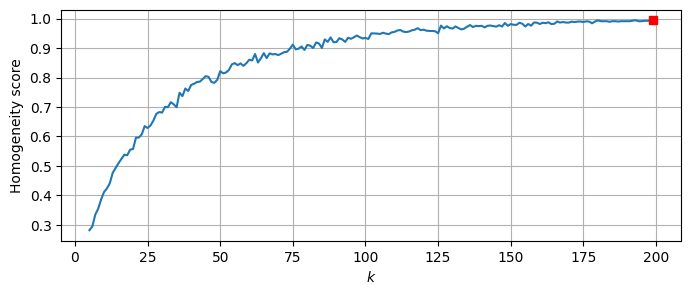

In [63]:
from sklearn.metrics import homogeneity_score

homogeneity_scores = [homogeneity_score(y, model.labels_) for model in kmeans_per_k]
best_homogeneity_index = np.argmax(homogeneity_scores)
best_homogeneity_k = k_range[best_homogeneity_index]
best_homogeneity_score = homogeneity_scores[best_homogeneity_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, homogeneity_scores)
plt.xlabel("$k$")
plt.ylabel("Homogeneity score")
plt.plot(best_homogeneity_k, best_homogeneity_score, "rs")
plt.grid()
plt.show()

# Penalized Homogeneity

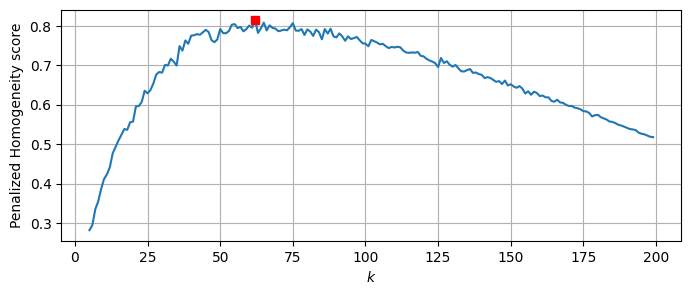

In [64]:
def penalized_homogeneity_score(homogeneity_scores, k_range, max_clusters=40, penalty_weight=0.003):
    penalized_scores = []
    for k, score in zip(k_range, homogeneity_scores):
        penalty = 0
        if k > max_clusters:
            penalty = (k - max_clusters) * penalty_weight
        penalized_score = max(score - penalty, 0) 
        penalized_scores.append(penalized_score)
    
    return penalized_scores

penalized_scores = penalized_homogeneity_score(homogeneity_scores, k_range)

best_penalized_index = np.argmax(penalized_scores)
best_penalized_k = k_range[best_penalized_index]
best_penalized_score = penalized_scores[best_penalized_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, penalized_scores)
plt.xlabel("$k$")
plt.ylabel("Penalized Homogeneity score")
plt.plot(best_penalized_k, best_penalized_score, "rs")
plt.grid()
plt.show()


# Completeness

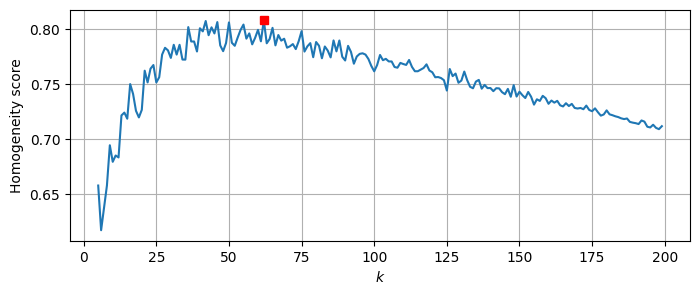

In [65]:
from sklearn.metrics import completeness_score

homogeneity_scores = [completeness_score(y, model.labels_) for model in kmeans_per_k]
best_homogeneity_index = np.argmax(homogeneity_scores)
best_homogeneity_k = k_range[best_homogeneity_index]
best_homogeneity_score = homogeneity_scores[best_homogeneity_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, homogeneity_scores)
plt.xlabel("$k$")
plt.ylabel("Homogeneity score")
plt.plot(best_homogeneity_k, best_homogeneity_score, "rs")
plt.grid()
plt.show()

# V-Measure

In [71]:
from sklearn.metrics.cluster import v_measure_score

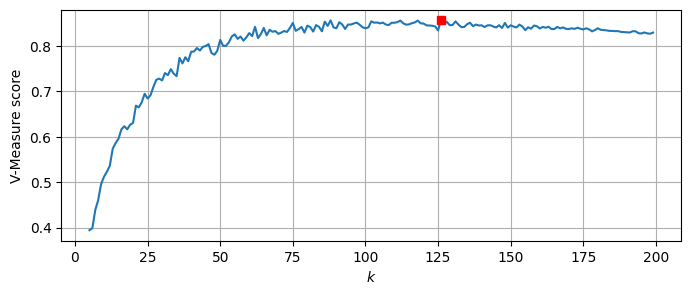

In [73]:
v_scores = [v_measure_score(y, model.labels_) for model in kmeans_per_k]
best_v_index = np.argmax(v_scores)
best_v_k = k_range[best_v_index]
best_v_score = v_scores[best_v_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, v_scores)
plt.xlabel("$k$")
plt.ylabel("V-Measure score")
plt.plot(best_v_k, best_v_score, "rs")
plt.grid()
plt.show()

# Customized V-Measure (Combined Penalized Homogeneity and Completeness)

In [66]:
from sklearn.metrics.cluster import homogeneity_score, completeness_score

def penalized_v_measure(labels_true, labels_pred, k, max_clusters=40, penalty_weight=0.003):
    """
    Compute a penalized V-measure score.

    :param labels_true: array, shape = [n_samples] Ground truth class labels to be used as a reference.
    :param labels_pred: array, shape = [n_samples] Cluster labels to evaluate.
    :param k: int, The number of clusters used.
    :param max_clusters: int, The maximum number of clusters without penalty.
    :param penalty_weight: float, The weight of the penalty for over-clustering.
    :return: float, Penalized V-measure score.
    """

    # Calculate standard homogeneity and completeness
    homogeneity = homogeneity_score(labels_true, labels_pred)
    completeness = completeness_score(labels_true, labels_pred)

    # Apply penalty to homogeneity if necessary
    if k > max_clusters:
        penalty = (k - max_clusters) * penalty_weight
        homogeneity = max(homogeneity - penalty, 0)

    # Calculate V-measure from penalized homogeneity and standard completeness
    if homogeneity + completeness == 0:
        return 0.0
    return 2 * (homogeneity * completeness) / (homogeneity + completeness)


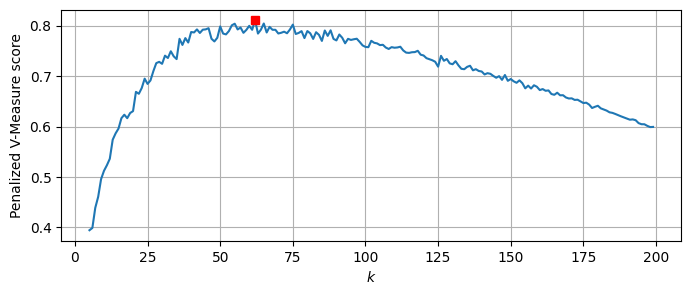

In [74]:
penalized_v_scores = [penalized_v_measure(y, model.labels_, k) for k, model in zip(k_range, kmeans_per_k)]
best_v_index = np.argmax(penalized_v_scores)
best_v_k = k_range[best_v_index]
best_v_score = penalized_v_scores[best_v_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, penalized_v_scores)
plt.xlabel("$k$")
plt.ylabel("Penalized V-Measure score")
plt.plot(best_v_k, best_v_score, "rs")
plt.grid()
plt.show()

In [75]:
best_v_k

62

In [76]:
best_v_score

0.8108364796473918

# GMM with penalized v-measure

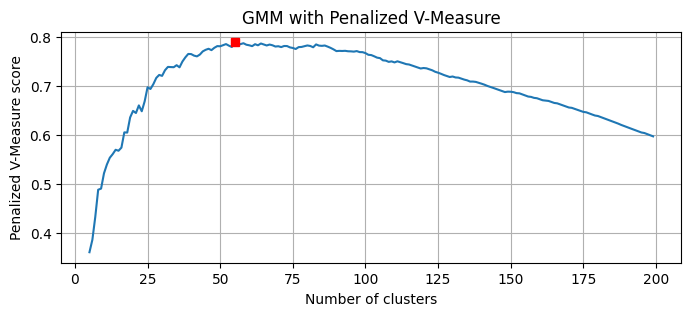

In [80]:
penalized_v_scores_gmm = []
for n_clusters in k_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(X)

    v_score = penalized_v_measure(y, gmm_labels, n_clusters)
    penalized_v_scores_gmm.append(v_score)

best_v_index_gmm = np.argmax(penalized_v_scores_gmm)
best_v_k_gmm = k_range[best_v_index_gmm]
best_v_score_gmm = penalized_v_scores_gmm[best_v_index_gmm]

plt.figure(figsize=(8, 3))
plt.plot(k_range, penalized_v_scores_gmm)
plt.xlabel('Number of clusters')
plt.ylabel('Penalized V-Measure score')
plt.title('GMM with Penalized V-Measure')
plt.plot(best_v_k_gmm, best_v_score_gmm, "rs")
plt.grid()
plt.show()


In [81]:
best_v_k_gmm

55

In [82]:
best_v_score_gmm

0.7887663262545402

# Agglomerative Clustering (euclidean-ward) with Penalized V-Measure

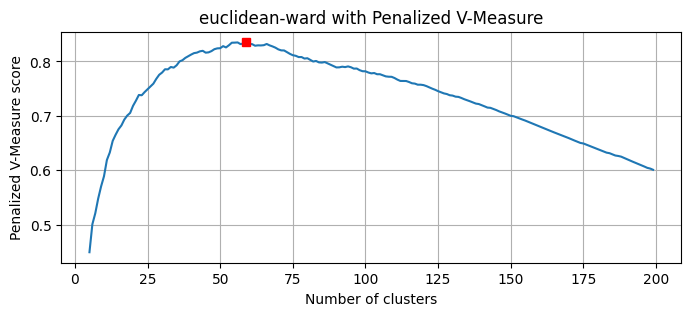

In [84]:
penalized_v_scores_euclidean_ward = []
for n_clusters in k_range:
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters,
                                             affinity='euclidean',
                                             linkage='ward')
    agg_labels = agg_clustering.fit_predict(X)

    v_score = penalized_v_measure(y, agg_labels, n_clusters)
    penalized_v_scores_euclidean_ward.append(v_score)

best_v_index_euclidean_ward = np.argmax(penalized_v_scores_euclidean_ward)
best_v_k_euclidean_ward = k_range[best_v_index_euclidean_ward]
best_v_score_euclidean_ward = penalized_v_scores_euclidean_ward[best_v_index_euclidean_ward]

plt.figure(figsize=(8, 3))
plt.plot(k_range, penalized_v_scores_euclidean_ward)
plt.xlabel('Number of clusters')
plt.ylabel('Penalized V-Measure score')
plt.title('euclidean-ward with Penalized V-Measure')
plt.plot(best_v_k_euclidean_ward, best_v_score_euclidean_ward, "rs")
plt.grid()
plt.show()


In [85]:
best_v_k_euclidean_ward

59

In [86]:
best_v_score_euclidean_ward

0.8353646125668721

## Agg k=59 result

In [ ]:
agg_clustering_59 = AgglomerativeClustering(n_clusters=59,
                                             affinity='euclidean',
                                             linkage='ward')
agg_clustering_59.fit(X)

for cluster_id in np.unique(agg_clustering_59.labels_):
    print("Cluster", cluster_id)
    in_cluster = agg_clustering_59.labels_==cluster_id
    faces = olivetti.data[in_cluster]
    labels = y[in_cluster]
    plot_faces(faces, labels)